In [1]:
from itertools import cycle

import datasets
import torch
import torch.nn.functional as F
from matplotlib import pyplot as plt
from torch import nn
from torch.utils.data import DataLoader
from transformers import AutoModel, AutoTokenizer

from sae.data import chunk_and_tokenize

%load_ext autoreload
%autoreload 2

In [2]:
torch.manual_seed(42)

In [3]:
dataset = datasets.load_dataset(
    "togethercomputer/RedPajama-Data-1T-Sample", split="train[:1000]"
)
tokenizer = AutoTokenizer.from_pretrained("gpt2")
dataset = chunk_and_tokenize(dataset, tokenizer, max_seq_len=32)
model = AutoModel.from_pretrained("gpt2", device_map={"": 0})

In [4]:
class Regression(nn.Module):
    def __init__(self, d_in, d_out):
        super().__init__()
        self.d_in = d_in
        self.d_out = d_out
        self.linear = nn.Linear(d_in, d_out)

    def forward(self, x):
        x = self.linear(x)
        return x


class NuclearNormLoss(nn.Module):
    def __init__(self, lam=0.01, rank=None):
        super().__init__()
        self.lam = lam
        self.rank = rank or 1

    def forward(self, pred, target, weight):
        mse_loss = torch.mean((pred - target) ** 2)
        _, S, _ = torch.linalg.svd(weight)
        # penalize all other ranks
        nuclear_norm = torch.sum(S[self.rank :])
        return mse_loss + self.lam * nuclear_norm, mse_loss, nuclear_norm

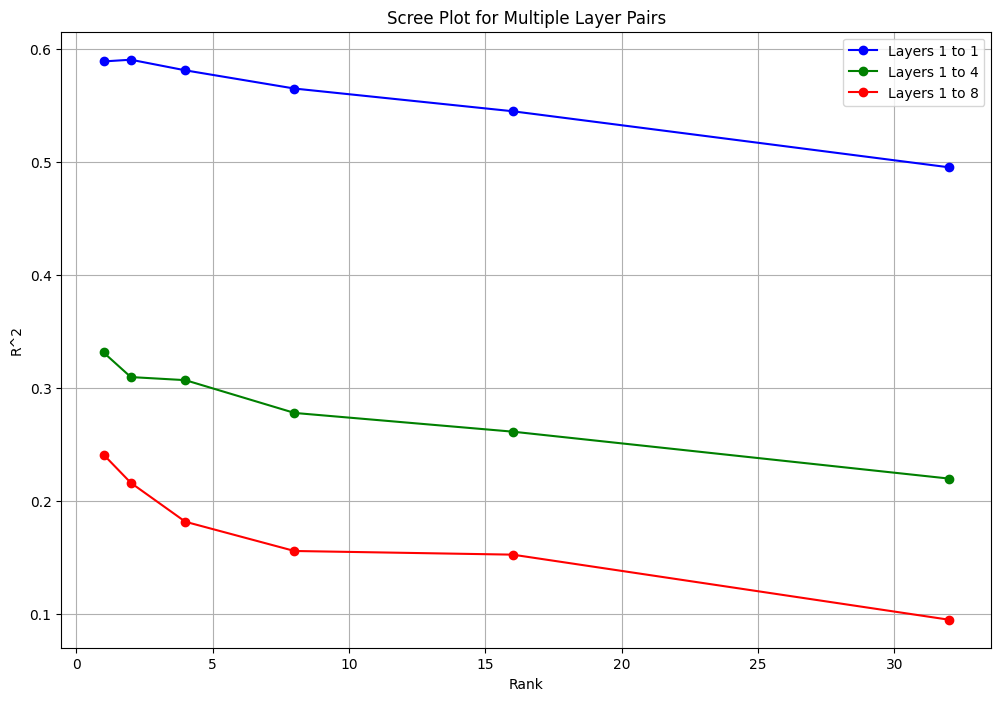

In [6]:
def train_and_evaluate(
    model,
    dataset,
    i,
    j,
    rank,
    batch_size=64,
    lam=0.1,
    lr=1e-2,
    steps=20,
    eval_steps=10,
    device="cuda",
):
    split_dataset = dataset.train_test_split(test_size=0.2)
    train_dataloader = DataLoader(
        split_dataset["train"], batch_size=batch_size, shuffle=True
    )
    test_dataloader = DataLoader(
        split_dataset["test"], batch_size=batch_size, shuffle=False
    )

    linear_model = Regression(d_in=model.config.n_embd, d_out=model.config.n_embd).to(
        device
    )

    nn.init.zeros_(linear_model.linear.weight)
    nn.init.zeros_(linear_model.linear.bias)

    criterion = NuclearNormLoss(lam=lam, rank=rank)
    opt = torch.optim.SGD(linear_model.parameters(), lr=lr)

    train_iter = cycle(train_dataloader)

    for step in range(steps):
        train_batch = next(train_iter)
        opt.zero_grad()

        with torch.no_grad():
            model_out = model(
                train_batch["input_ids"].to(device), output_hidden_states=True
            )
        layer_i_acts, layer_j_acts = (
            model_out.hidden_states[i],
            model_out.hidden_states[j],
        )

        pred, target = (
            linear_model(F.normalize(layer_i_acts, p=2, dim=-1)),
            F.normalize(layer_j_acts, p=2, dim=-1),
        )
        loss, l2, nnorm = criterion(pred, target, linear_model.linear.weight)

        with torch.no_grad():
            l2_full = torch.mean((pred - target) ** 2, dim=(0, 2))
            var = torch.var(target, dim=(0, 2))
            fvu = (l2_full / var).mean()

        loss.backward()
        opt.step()

    # Evaluate on test set
    linear_model.eval()
    total_fvu = 0

    with torch.no_grad():
        for i, test_batch in enumerate(test_dataloader):
            model_out = model(
                test_batch["input_ids"].to(device), output_hidden_states=True
            )
            layer_i_acts, layer_j_acts = (
                model_out.hidden_states[i],
                model_out.hidden_states[j],
            )
            pred, target = (
                F.normalize(
                    linear_model(F.normalize(layer_i_acts, p=2, dim=-1)), p=2, dim=-1
                ),
                F.normalize(layer_j_acts, p=2, dim=-1),
            )
            l2_full = torch.mean((pred - target) ** 2, dim=(0, 2))
            var = torch.var(target, dim=(0, 2))
            fvu = (l2_full / var).mean()

            total_fvu += fvu.item()

            if i >= eval_steps:
                break

    test_fvu = total_fvu / eval_steps
    test_r2 = 1 - test_fvu

    return test_r2


def create_scree_plot(model, dataset, layer_pairs, ranks):
    plt.figure(figsize=(12, 8))

    colors = ["b", "g", "r", "c", "m", "y", "k"]  # Add more colors if needed

    for idx, (i, j) in enumerate(layer_pairs):
        r2_values = []
        for rank in ranks:
            r2 = train_and_evaluate(model, dataset, i, j, rank, steps=20)
            r2_values.append(r2)

        color = colors[idx % len(colors)]
        plt.plot(ranks, r2_values, f"{color}o-", label=f"Layers {i} to {j}")

    plt.xlabel("Rank")
    plt.ylabel("R^2")
    plt.title("Scree Plot for Multiple Layer Pairs")
    plt.grid(True)
    plt.legend()
    plt.show()


# Usage
ranks = [1, 2, 4, 8, 16, 32]
layer_pairs = [(1, 1), (1, 4), (1, 8)]  # Add more layer pairs as needed
create_scree_plot(model, dataset, layer_pairs, ranks)